In [ ]:
##########################################
# This notebook is used for intial data exploration for the capstone project
##########################################


First, we import the data

In [1]:
import pandas as pd
import numpy as np
import glob
from IPython.display import display # Allows the use of display() for DataFrames


#data = pd.read_csv('data/transactions_200607.csv')  #import one file

#import all csvs (courtesy of http://stackoverflow.com/questions/20906474/import-multiple-csv-files-into-pandas-and-concatenate-into-one-dataframe)

path =r'data' # use your path
allFiles = glob.glob(path + "/tr*.csv")

#print allFiles
data = pd.DataFrame()
list_ = []
for file_ in allFiles:
    df = pd.read_csv(file_,index_col=None, header=0)
    list_.append(df)
data = pd.concat(list_)

#print(data.head(20))


print('Before DropNA',len(data))
data=data.dropna()
print('After DropNA',len(data))

#consider dropping these categories, but will try with them first.

#data = data[data.CUST_PRICE_SENSITIVITY != 'XX']
#data = data[data.CUST_LIFESTAGE != 'OT']
#print('After Uninteresting categories',len(data))
#list(data.columns.values)


('Before DropNA', 31057875)
('After DropNA', 21967768)



Reformat the data into a wide dataset using Prod_code_20 as the lowest level of aggregation.  This is as recommended by Apeh et al. in Customer Profile Classification Using Transactional Data (https://core.ac.uk/download/pdf/4899037.pdf).  Then, to predict the basket, we just apply the value for the predicted customer.

In [4]:
#create customerprofiles.  Simplest version will be to sum spend in each category in PROD_CODE_20, keeping the target variable as well
#pivot code from http://stackoverflow.com/questions/41046766/using-and-graphing-the-results-of-a-crosstab-dataframe-in-python

data_cross=data.pivot_table(index='CUST_CODE', columns='PROD_CODE_20', values='SPEND', aggfunc=np.sum, fill_value=0)
data_cross.reset_index(level=['CUST_CODE'], inplace=True)

#group the variables that are unique to each basket
byCustomer=data.groupby(['CUST_CODE'])
targetsByCustomer=pd.DataFrame(byCustomer['CUST_LIFESTAGE', 'CUST_PRICE_SENSITIVITY'].first())
targetsByCustomer.reset_index(level=['CUST_CODE'], inplace=True)

sumsByCustomer=pd.DataFrame(byCustomer['SPEND'].sum())
sumsByCustomer.reset_index(level=['CUST_CODE'], inplace=True)

data_cross_day=data.pivot_table(index='CUST_CODE', columns='SHOP_WEEKDAY', values='SPEND', aggfunc=np.sum, fill_value=0)
data_cross_day.reset_index(level=['CUST_CODE'], inplace=True)
data_cross_basketsize = data.pivot_table(index='CUST_CODE', columns='BASKET_SIZE', values='SPEND', aggfunc=len, fill_value=0)
data_cross_basketsize.reset_index(level=['CUST_CODE'], inplace=True)
data_cross_baskettype = data.pivot_table(index='CUST_CODE', columns='BASKET_TYPE', values='SPEND', aggfunc=len, fill_value=0)
data_cross_baskettype.reset_index(level=['CUST_CODE'], inplace=True)


data_cross = pd.merge(data_cross, data_cross_day, how='inner', on = 'CUST_CODE')
data_cross = pd.merge(data_cross, data_cross_basketsize, how='inner', on = 'CUST_CODE')
data_cross = pd.merge(data_cross, data_cross_baskettype, how='inner', on = 'CUST_CODE')

data_cross = pd.merge(data_cross, sumsByCustomer, how='inner', on = 'CUST_CODE')
data_cross = pd.merge(data_cross, targetsByCustomer, how='inner', on = 'CUST_CODE')

#reset the index to what it should be for the rest of the analysis
data_cross.set_index(['CUST_CODE'], inplace=True)

print(data_cross.head(5))
#list(data_cross.columns.values)
#print(data_cross.describe(include='all'))

                DEP00001  DEP00002  DEP00003  DEP00004  DEP00005  DEP00006  \
CUST_CODE                                                                    
CUST0000000031     14.41     19.62      1.39     21.96     13.28       0.0   
CUST0000000068    266.45     50.44     71.24      1.68      6.86       0.0   
CUST0000000108      0.00      0.00      4.32      0.00      0.00       0.0   
CUST0000000131      2.34     30.37      0.00      4.86      2.46       0.0   
CUST0000000164      2.34      0.00      0.00      0.00      0.00       0.0   

                DEP00007  DEP00008  DEP00009  DEP00010  \
CUST_CODE                                                
CUST0000000031       0.0    111.16      3.21     34.87   
CUST0000000068       0.0    153.07      2.56     11.08   
CUST0000000108       0.0      1.76      0.00      2.98   
CUST0000000131       0.0    130.05      2.78     30.59   
CUST0000000164       0.0      2.77      0.00      1.29   

                         ...               L  

In [3]:


print(data_cross_day.head())
print(data_cross_basketsize.head())
print(data_cross_baskettype.head())

SHOP_WEEKDAY       CUST_CODE       1       2       3       4       5       6  \
0             CUST0000000031  208.17  183.57  162.41  136.72  260.78  159.22   
1             CUST0000000068  356.85  303.24  250.42  341.69  231.09  298.53   
2             CUST0000000108    8.93    0.00    0.00    0.00    0.00    0.00   
3             CUST0000000131  176.47  251.85  117.20  162.75  151.36   34.75   
4             CUST0000000164   22.89   20.13   22.95   20.60   17.28   11.25   

SHOP_WEEKDAY       7  
0              99.17  
1             252.99  
2               8.93  
3              39.16  
4              19.45  
BASKET_SIZE       CUST_CODE     L    M   S
0            CUST0000000031   301  294  62
1            CUST0000000068  1028  285  71
2            CUST0000000108     0   12   0
3            CUST0000000131   255   92  17
4            CUST0000000164     0   61  44
BASKET_TYPE       CUST_CODE  Full Shop  Small Shop  Top Up  XX
0            CUST0000000031         44         268     345  

# Some visualizations

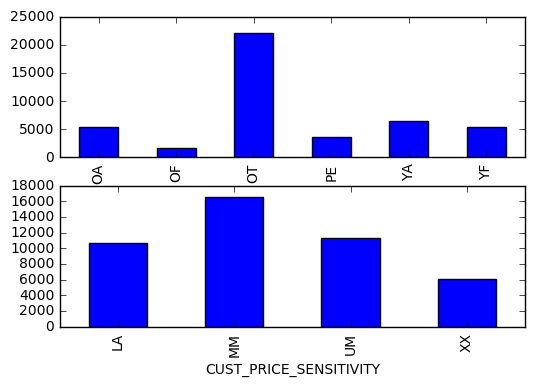

In [5]:
import matplotlib.pyplot as plt  #http://pandas.pydata.org/pandas-docs/stable/visualization.html
%matplotlib inline

plt.figure()

#http://pbpython.com/simple-graphing-pandas.html
    
plt.subplot(211)  
lsPlot = data_cross.groupby(['CUST_LIFESTAGE'])['SPEND'].count().plot(kind='bar')
plt.subplot(212)  
psPlot = data_cross.groupby(['CUST_PRICE_SENSITIVITY'])['SPEND'].count().plot(kind='bar')



# Split the data #should probably consider stratified sampling here.

In [6]:
#create the training, testing split.  can't use sklearn.cross_validation.train_test_split since I have two targets

#create a copy:
data_cross_for_balanced_PS = data_cross
data_cross_for_balanced_LS = data_cross

#first do a 70-30 split.  
train_X=data_cross.sample(frac=0.7,random_state=42)
test_X=data_cross.drop(train_X.index)

#pop off the classifiers
train_y = train_X[["CUST_LIFESTAGE","CUST_PRICE_SENSITIVITY"]] #potentially for use in multi-output decision trees
train_y_LS = train_X.pop("CUST_LIFESTAGE")
train_y_PS = train_X.pop("CUST_PRICE_SENSITIVITY")

test_y = test_X[["CUST_LIFESTAGE","CUST_PRICE_SENSITIVITY"]] #potentially for use in multi-output decision trees
test_y_LS = test_X.pop("CUST_LIFESTAGE")
test_y_PS = test_X.pop("CUST_PRICE_SENSITIVITY")


# Downsample the training so all strata are equal

In [7]:
#based on  https://www.datarobot.com/blog/classification-with-scikit-learn/

rng = np.random.RandomState(42)

print(data_cross_for_balanced_PS.groupby(['CUST_PRICE_SENSITIVITY'])['SPEND'].count())
min_count_PS = min(data_cross_for_balanced_PS.groupby(['CUST_PRICE_SENSITIVITY'])['SPEND'].count())

indices_LA = np.where(data_cross_for_balanced_PS.CUST_PRICE_SENSITIVITY == 'LA')[0]
rng.shuffle(indices_LA)
data_cross_for_balanced_PS = data_cross_for_balanced_PS.drop(data_cross_for_balanced_PS.index[indices_LA[min_count_PS:]])

indices_MM = np.where(data_cross_for_balanced_PS.CUST_PRICE_SENSITIVITY == 'MM')[0]
rng.shuffle(indices_MM)
data_cross_for_balanced_PS = data_cross_for_balanced_PS.drop(data_cross_for_balanced_PS.index[indices_MM[min_count_PS:]])

indices_UM = np.where(data_cross_for_balanced_PS.CUST_PRICE_SENSITIVITY == 'UM')[0]
rng.shuffle(indices_UM)
data_cross_for_balanced_PS = data_cross_for_balanced_PS.drop(data_cross_for_balanced_PS.index[indices_UM[min_count_PS:]])

indices_XX = np.where(data_cross_for_balanced_PS.CUST_PRICE_SENSITIVITY == 'XX')[0]
rng.shuffle(indices_XX)
data_cross_for_balanced_PS = data_cross_for_balanced_PS.drop(data_cross_for_balanced_PS.index[indices_XX[min_count_PS:]])

print(data_cross_for_balanced_PS.groupby(['CUST_PRICE_SENSITIVITY'])['SPEND'].count())

print(data_cross_for_balanced_LS.groupby(['CUST_LIFESTAGE'])['SPEND'].count())
min_count_LS = min(data_cross_for_balanced_LS.groupby(['CUST_LIFESTAGE'])['SPEND'].count())

indices_OA = np.where(data_cross_for_balanced_LS.CUST_LIFESTAGE == 'OA')[0]
rng.shuffle(indices_OA)
data_cross_for_balanced_LS = data_cross_for_balanced_LS.drop(data_cross_for_balanced_LS.index[indices_OA[min_count_LS:]])

indices_OF = np.where(data_cross_for_balanced_LS.CUST_LIFESTAGE == 'OF')[0]
rng.shuffle(indices_OF)
data_cross_for_balanced_LS = data_cross_for_balanced_LS.drop(data_cross_for_balanced_LS.index[indices_OF[min_count_LS:]])

indices_OT = np.where(data_cross_for_balanced_LS.CUST_LIFESTAGE == 'OT')[0]
rng.shuffle(indices_OT)
data_cross_for_balanced_LS = data_cross_for_balanced_LS.drop(data_cross_for_balanced_LS.index[indices_OT[min_count_LS:]])

indices_PE = np.where(data_cross_for_balanced_LS.CUST_LIFESTAGE == 'PE')[0]
rng.shuffle(indices_PE)
data_cross_for_balanced_LS = data_cross_for_balanced_LS.drop(data_cross_for_balanced_LS.index[indices_PE[min_count_LS:]])

indices_YA = np.where(data_cross_for_balanced_LS.CUST_LIFESTAGE == 'YA')[0]
rng.shuffle(indices_YA)
data_cross_for_balanced_LS = data_cross_for_balanced_LS.drop(data_cross_for_balanced_LS.index[indices_YA[min_count_LS:]])

indices_YF = np.where(data_cross_for_balanced_LS.CUST_LIFESTAGE == 'YF')[0]
rng.shuffle(indices_YF)
data_cross_for_balanced_LS = data_cross_for_balanced_LS.drop(data_cross_for_balanced_LS.index[indices_YF[min_count_LS:]])


print(data_cross_for_balanced_LS.groupby(['CUST_LIFESTAGE'])['SPEND'].count())



#first do a 70-30 split.  
balanced_PS_train_X=data_cross_for_balanced_PS.sample(frac=0.7,random_state=42)
balanced_PS_test_X=data_cross_for_balanced_PS.drop(balanced_PS_train_X.index)

#pop off the classifiers
balanced_PS_train_y_LS = balanced_PS_train_X.pop("CUST_LIFESTAGE") #don't need this
balanced_PS_train_y_PS = balanced_PS_train_X.pop("CUST_PRICE_SENSITIVITY")

balanced_PS_test_y_LS = balanced_PS_test_X.pop("CUST_LIFESTAGE") #don't need this
balanced_PS_test_y_PS = balanced_PS_test_X.pop("CUST_PRICE_SENSITIVITY")

#first do a 70-30 split.  
balanced_LS_train_X=data_cross_for_balanced_LS.sample(frac=0.7,random_state=42)
balanced_LS_test_X=data_cross_for_balanced_LS.drop(balanced_LS_train_X.index)

#pop off the classifiers
balanced_LS_train_y_LS = balanced_LS_train_X.pop("CUST_LIFESTAGE")
balanced_LS_train_y_PS = balanced_LS_train_X.pop("CUST_PRICE_SENSITIVITY") #don't need this

balanced_LS_test_y_LS = balanced_LS_test_X.pop("CUST_LIFESTAGE")
balanced_LS_test_y_PS = balanced_LS_test_X.pop("CUST_PRICE_SENSITIVITY") #don't need this

CUST_PRICE_SENSITIVITY
LA    10689
MM    16603
UM    11290
XX     6067
Name: SPEND, dtype: int64
CUST_PRICE_SENSITIVITY
LA    6067
MM    6067
UM    6067
XX    6067
Name: SPEND, dtype: int64
CUST_LIFESTAGE
OA     5359
OF     1756
OT    22126
PE     3600
YA     6375
YF     5433
Name: SPEND, dtype: int64
CUST_LIFESTAGE
OA    1756
OF    1756
OT    1756
PE    1756
YA    1756
YF    1756
Name: SPEND, dtype: int64


In [8]:
#upsampling for LS, per http://www.site.uottawa.ca/~nat/Courses/csi5388/Class-Imbalances.ppt
from sklearn.utils import resample
data_cross_upsampled_LS = data_cross

print(data_cross_upsampled_LS.groupby(['CUST_LIFESTAGE'])['SPEND'].count())
max_count_LS = max(data_cross_upsampled_LS.groupby(['CUST_LIFESTAGE'])['SPEND'].count())

subset_OA = data_cross_upsampled_LS[data_cross_upsampled_LS.CUST_LIFESTAGE == 'OA']
up_subset_OA = resample(subset_OA, n_samples=max_count_LS)
subset_OT = data_cross_upsampled_LS[data_cross_upsampled_LS.CUST_LIFESTAGE == 'OT']
up_subset_OT = resample(subset_OT, n_samples=max_count_LS)
subset_PE = data_cross_upsampled_LS[data_cross_upsampled_LS.CUST_LIFESTAGE == 'PE']
up_subset_PE = resample(subset_PE, n_samples=max_count_LS)
subset_YA = data_cross_upsampled_LS[data_cross_upsampled_LS.CUST_LIFESTAGE == 'YA']
up_subset_YA = resample(subset_YA, n_samples=max_count_LS)
subset_OF = data_cross_upsampled_LS[data_cross_upsampled_LS.CUST_LIFESTAGE == 'OF']
up_subset_OF = resample(subset_OF, n_samples=max_count_LS)
subset_YF = data_cross_upsampled_LS[data_cross_upsampled_LS.CUST_LIFESTAGE == 'YF']
up_subset_YF = resample(subset_YF, n_samples=max_count_LS)

data_cross_upsampled_LS = pd.concat([up_subset_OA, subset_OT,up_subset_OF, up_subset_YA, up_subset_YF, up_subset_PE ])

print(data_cross_upsampled_LS.groupby(['CUST_LIFESTAGE'])['SPEND'].count())

#first do a 70-30 split.  
upsampled_LS_train_X=data_cross_upsampled_LS.sample(frac=0.7,random_state=42)
upsampled_LS_test_X=data_cross_upsampled_LS.drop(upsampled_LS_train_X.index)

#pop off the classifiers
upsampled_LS_train_y_LS = upsampled_LS_train_X.pop("CUST_LIFESTAGE")
upsampled_LS_train_y_PS = upsampled_LS_train_X.pop("CUST_PRICE_SENSITIVITY") #don't need this

upsampled_LS_test_y_LS = upsampled_LS_test_X.pop("CUST_LIFESTAGE")
upsampled_LS_test_y_PS = upsampled_LS_test_X.pop("CUST_PRICE_SENSITIVITY") #don't need this

CUST_LIFESTAGE
OA     5359
OF     1756
OT    22126
PE     3600
YA     6375
YF     5433
Name: SPEND, dtype: int64
CUST_LIFESTAGE
OA    22126
OF    22126
OT    22126
PE    22126
YA    22126
YF    22126
Name: SPEND, dtype: int64


# Create some helper functions

In [9]:
from sklearn.metrics import confusion_matrix

#Create a function to test classifiers and create simple output
def tryClassifier_PS (title,psClassifier, train_X, test_X, train_y_PS, test_y_PS):
    ps_pred_train = psClassifier.predict(train_X)
    ps_pred_test = psClassifier.predict(test_X)
    
    print(title)
    print('Price Sensitivity Training: ', psClassifier.score(train_X, train_y_PS))
    print(confusion_matrix(train_y_PS, ps_pred_train, labels=["LA", "MM", "UM","XX"]))
    print('Price Sensitivity Testing: ', psClassifier.score(test_X, test_y_PS))
    print(confusion_matrix(test_y_PS, ps_pred_test, labels=["LA", "MM", "UM","XX"]))


def tryClassifier_LS (title, lsClassifier, train_X, test_X, train_y_LS, test_y_LS):

    ls_pred_train = lsClassifier.predict(train_X)
    ls_pred_test = lsClassifier.predict(test_X)
    
    print('LifeStage Training: ', lsClassifier.score(train_X, train_y_LS))
    print(confusion_matrix(train_y_LS, ls_pred_train, labels=["OA", "OF", "OT","PE","YA","YF"]))
    print('LifeStage Testing: ', lsClassifier.score(test_X, test_y_LS))
    print(confusion_matrix(test_y_LS, ls_pred_test, labels=["OA", "OF", "OT","PE","YA","YF"]))
 
    
from sklearn.metrics import accuracy_score

#create an accuracy metric
def performance_metric(y_true, y_predict):
    """ Calculates and returns the performance score between 
        true and predicted values based on the metric chosen. """
    
    # TODO: Calculate the performance score between 'y_true' and 'y_predict'
    score = accuracy_score(y_true, y_predict)
    
    # Return the score
    return score
from sklearn.metrics import make_scorer
scoring_fnc = make_scorer(performance_metric)

# try the classifiers

In [ ]:
from sklearn.ensemble import RandomForestClassifier #using scikitlearn 0.17.1

print('Unbalanced:')

rfc_ps = RandomForestClassifier(n_estimators = 10000,random_state=42, criterion="entropy"
                                , max_features = 10
                                #, max_leaf_nodes=1000
                                #, min_samples_leaf=20
                                , oob_score=True
                               )
rfc_ls = RandomForestClassifier(n_estimators = 10000,random_state=42, criterion="entropy"
                                , max_features = 10
                                #, max_leaf_nodes=1000
                                #, min_samples_leaf=20
                                , oob_score=True
                               )
#need to handle categorical variables either through pandas.getDummies or http://scikit-learn.org/dev/modules/generated/sklearn.preprocessing.OneHotEncoder.html#sklearn.preprocessing.OneHotEncoder
#train_X_num

#print(train_X_dummied.head(10))
#print(list(train_X_dummied.columns.values))

rfc_ps = rfc_ps.fit(train_X, train_y_PS)
rfc_ls = rfc_ls.fit(train_X, train_y_LS)

print ('Recall that running training data back through the random forest is not as good an indicator of performance as the OOB score')

print('Price Sensitivity OOB: ', rfc_ps.oob_score_)
tryClassifier_PS ("Random Forest",rfc_ps, train_X, test_X, train_y_PS, test_y_PS)

print('Life Stage OOB: ', rfc_ls.oob_score_)
tryClassifier_LS ("Random Forest", rfc_ls, train_X, test_X, train_y_LS, test_y_LS)

print('Balanced:')

rfc_balanced_ps = RandomForestClassifier(n_estimators = 10000,random_state=42, criterion="entropy"
                                , max_features = 10
                                #, max_leaf_nodes=1000
                                #, min_samples_leaf=20
                                , oob_score=True
                               )
rfc_balanced_ls = RandomForestClassifier(n_estimators = 10000,random_state=42, criterion="entropy"
                                , max_features = 10
                                #, max_leaf_nodes=1000
                                #, min_samples_leaf=20
                                , oob_score=True
                               )
#need to handle categorical variables either through pandas.getDummies or http://scikit-learn.org/dev/modules/generated/sklearn.preprocessing.OneHotEncoder.html#sklearn.preprocessing.OneHotEncoder
#train_X_num

#print(train_X_dummied.head(10))
#print(list(train_X_dummied.columns.values))

rfc_balanced_ps = rfc_balanced_ps.fit(balanced_PS_train_X, balanced_PS_train_y_PS)
rfc_balanced_ls = rfc_balanced_ls.fit(balanced_LS_train_X, balanced_LS_train_y_LS)

print('Price Sensitivity OOB: ', rfc_ps.oob_score_)
tryClassifier_PS ("Random Forest",rfc_balanced_ps, balanced_PS_train_X, test_X, balanced_PS_train_y_PS, test_y_PS)

print('Life Stage OOB: ', rfc_ls.oob_score_)
tryClassifier_LS ("Random Forest", rfc_balanced_ls, balanced_LS_train_X, test_X, balanced_LS_train_y_LS, test_y_LS)


Unbalanced:


##Sample output

Unbalanced:
Recall that running training data back through the random forest is not as good an indicator of performance as the OOB score
('Price Sensitivity OOB: ', 0.61323350611121774)
Random Forest
('Price Sensitivity Training: ', 1.0)
[[ 7467     0     0     0]
 [    0 11628     0     0]
 [    0     0  7936     0]
 [    0     0     0  4223]]
('Price Sensitivity Testing: ', 0.61612541993281078)
[[1150 1783  133  156]
 [ 457 3696  666  156]
 [  42 1551 1670   91]
 [  15   70   22 1737]]
('Life Stage OOB: ', 0.51938951814167789)
('LifeStage Training: ', 0.99910411467332183)
[[ 3717     0     6     0     0     0]
 [    0  1253     2     0     0     0]
 [    0     0 15496     0     0     0]
 [    0     0     3  2500     0     0]
 [    0     0    12     0  4457     0]
 [    0     0     5     0     0  3803]]
('LifeStage Testing: ', 0.51213139231056359)
[[  56    0 1481   36    2   61]
 [   0    0  369    2    0  130]
 [  50    1 6219   54    3  303]
 [  54    0  921  114    0    8]
 [  25    0 1723    7    6  145]
 [   7    0 1146    7    0  465]]
Balanced:
('Price Sensitivity OOB: ', 0.61323350611121774)
Random Forest
('Price Sensitivity Training: ', 1.0)
[[4236    0    0    0]
 [   0 4228    0    0]
 [   0    0 4288    0]
 [   0    0    0 4236]]
('Price Sensitivity Testing: ', 0.71392310563643147)
[[2485  359  228  150]
 [1155 2532 1087  201]
 [ 206  322 2722  104]
 [  11    1    8 1824]]
('Life Stage OOB: ', 0.51938951814167789)
('LifeStage Training: ', 0.99959322033898301)
[[1223    0    0    0    0    1]
 [   0 1209    0    0    0    0]
 [   0    0 1250    0    0    0]
 [   0    0    1 1242    0    0]
 [   0    0    1    0 1236    0]
 [   0    0    0    0    0 1212]]
('LifeStage Testing: ', 0.51847704367301228)
[[ 617  117  191  431  188   92]
 [  12  376   24    9   35   45]
 [ 419  476 3364  903 1032  436]
 [  98   19  116  815   34   15]
 [ 171  173  235  197  953  177]
 [ 103  250  150   81  221  820]]

In [29]:
import sklearn

print('The scikit-learn version is {}.'.format(sklearn.__version__))
print('All code tested on 0.18.1')

The scikit-learn version is 0.18.1.
All code tested on 0.18.1


In [28]:
from sklearn.ensemble import GradientBoostingClassifier
gbc_ps = GradientBoostingClassifier(learning_rate=0.05, n_estimators=1000, max_depth=10)
balanced_gbc_ps = GradientBoostingClassifier(learning_rate=0.05, n_estimators=1000, max_depth=10)

#gbc_ls = GradientBoostingClassifier(learning_rate=0.05, n_estimators=1000, max_depth=10)

gbc_ps = gbc_ps.fit(train_X, train_y_PS)
balanced_gbc_ps = balanced_gbc_ps.fit(balanced_PS_train_X, balanced_PS_train_y_PS)
#gbc_ls = rfc_ls.fit(train_X, train_y_LS)

tryClassifier_PS ("Gradient Boosting Classifier",gbc_ps, train_X, test_X, train_y_PS, test_y_PS)
tryClassifier_PS ("Gradient Boosting Classifier",balanced_gbc_ps, balanced_PS_train_X, test_X, balanced_PS_train_y_PS, test_y_PS)


Gradient Boosting Classifier
('Price Sensitivity Training: ', 1.0)
[[ 7467     0     0     0]
 [    0 11628     0     0]
 [    0     0  7936     0]
 [    0     0     0  4223]]
('Price Sensitivity Testing: ', 0.6206047032474804)
[[1476 1512  154   80]
 [ 721 3342  822   90]
 [ 104 1374 1833   43]
 [  43   96   43 1662]]
Gradient Boosting Classifier
('Price Sensitivity Training: ', 1.0)
[[4236    0    0    0]
 [   0 4228    0    0]
 [   0    0 4288    0]
 [   0    0    0 4236]]
('Price Sensitivity Testing: ', 0.72340425531914898)
[[2476  471  171  104]
 [1073 2723 1039  140]
 [ 185  419 2678   72]
 [  14    6   11 1813]]


## sample output
Gradient Boosting Classifier
('Price Sensitivity Training: ', 1.0)
[[ 7467     0     0     0]
 [    0 11628     0     0]
 [    0     0  7936     0]
 [    0     0     0  4223]]
('Price Sensitivity Testing: ', 0.61814109742441214)
[[1466 1520  158   78]
 [ 740 3321  822   92]
 [ 102 1378 1833   41]
 [  47   91   46 1660]]
Gradient Boosting Classifier
('Price Sensitivity Training: ', 1.0)
[[4236    0    0    0]
 [   0 4228    0    0]
 [   0    0 4288    0]
 [   0    0    0 4236]]
('Price Sensitivity Testing: ', 0.72474804031354978)
[[2466  470  184  102]
 [1061 2759 1011  144]
 [ 185  435 2668   66]
 [  16    4    9 1815]]

In [13]:
from sklearn.ensemble import GradientBoostingClassifier
gbc_LS = GradientBoostingClassifier(learning_rate=0.05, n_estimators=1000, max_depth=10)
balanced_gbc_LS = GradientBoostingClassifier(learning_rate=0.05, n_estimators=1000, max_depth=10)

#gbc_ls = GradientBoostingClassifier(learning_rate=0.05, n_estimators=1000, max_depth=10)

gbc_LS = gbc_LS.fit(train_X, train_y_LS)
balanced_gbc_LS = balanced_gbc_LS.fit(balanced_LS_train_X, balanced_LS_train_y_LS)
#gbc_ls = rfc_ls.fit(train_X, train_y_LS)

tryClassifier_LS ("Gradient Boosting Classifier",gbc_LS, train_X, test_X, train_y_LS, test_y_LS)
tryClassifier_LS ("Gradient Boosting Classifier",balanced_gbc_LS, balanced_LS_train_X, test_X, balanced_LS_train_y_LS, test_y_LS)


('LifeStage Training: ', 0.99910411467332183)
[[ 3717     0     6     0     0     0]
 [    0  1253     2     0     0     0]
 [    0     0 15496     0     0     0]
 [    0     0     3  2500     0     0]
 [    0     0    12     0  4457     0]
 [    0     0     5     0     0  3803]]
('LifeStage Testing: ', 0.50727883538633822)
[[ 138    0 1305   87   61   45]
 [   9    2  370    4   18   98]
 [ 131    7 5936  130  190  236]
 [  98    0  783  197   10    9]
 [  58    0 1568   20  142  118]
 [  32    5 1144   10   54  380]]
('LifeStage Training: ', 0.99959322033898301)
[[1224    0    0    0    0    0]
 [   0 1209    0    0    0    0]
 [   0    0 1250    0    0    0]
 [   0    0    1 1242    0    0]
 [   0    0    1    0 1236    0]
 [   1    0    0    0    0 1211]]
('LifeStage Testing: ', 0.49092945128779397)
[[ 696  119  191  344  172  114]
 [  18  379   20    7   30   47]
 [ 666  581 3047  811  904  621]
 [ 153   17   96  771   32   28]
 [ 220  209  228  149  867  233]
 [ 115  283  148   6

In [29]:
from sklearn.neighbors import KNeighborsClassifier

knn_ps = KNeighborsClassifier(n_neighbors=10)
balanced_knn_ps = KNeighborsClassifier(n_neighbors=10)
#knn_ls = KNeighborsClassifier(n_neighbors=10)

knn_ps = knn_ps.fit(train_X,train_y_PS)
balanced_knn_ps = balanced_knn_ps.fit(balanced_PS_train_X,balanced_PS_train_y_PS)
#knn_ls = knn_ls.fit(train_X,train_y_LS)

tryClassifier_PS ("KNN Classifier",knn_ps, train_X, test_X, train_y_PS, test_y_PS)
tryClassifier_PS ("KNN Classifier",balanced_knn_ps, balanced_PS_train_X, test_X, balanced_PS_train_y_PS, test_y_PS)

KNN Classifier
('Price Sensitivity Training: ', 0.6076342228194791)
[[4091 2711  496  169]
 [2321 7977 1192  138]
 [1108 3497 3239   92]
 [ 259  197   83 3684]]
('Price Sensitivity Testing: ', 0.50272489734975734)
[[1319 1542  277   84]
 [1413 2768  724   70]
 [ 557 1685 1079   33]
 [ 113  114   49 1568]]
KNN Classifier
('Price Sensitivity Training: ', 0.65104779844596183)
[[2838  814  427  157]
 [1345 2025  744  114]
 [ 881 1033 2266  108]
 [ 162   74   69 3931]]
('Price Sensitivity Testing: ', 0.53049645390070921)
[[1968  764  358  132]
 [1904 1908 1027  136]
 [ 794  924 1548   88]
 [  89   33   40 1682]]


In [ ]:
## sample output
KNN Classifier
('Price Sensitivity Training: ', 0.6076342228194791)
[[4091 2711  496  169]
 [2321 7977 1192  138]
 [1108 3497 3239   92]
 [ 259  197   83 3684]]
('Price Sensitivity Testing: ', 0.50272489734975734)
[[1319 1542  277   84]
 [1413 2768  724   70]
 [ 557 1685 1079   33]
 [ 113  114   49 1568]]
KNN Classifier
('Price Sensitivity Training: ', 0.65104779844596183)
[[2838  814  427  157]
 [1345 2025  744  114]
 [ 881 1033 2266  108]
 [ 162   74   69 3931]]
('Price Sensitivity Testing: ', 0.53049645390070921)
[[1968  764  358  132]
 [1904 1908 1027  136]
 [ 794  924 1548   88]
 [  89   33   40 1682]]

In [18]:
from sklearn.neighbors import KNeighborsClassifier

knn_LS = KNeighborsClassifier(n_neighbors=10)
balanced_knn_LS = KNeighborsClassifier(n_neighbors=10)


knn_LS = knn_LS.fit(train_X,train_y_LS)
balanced_knn_LS = balanced_knn_LS.fit(balanced_LS_train_X,balanced_LS_train_y_LS)


tryClassifier_LS ("KNN Classifier",knn_LS, train_X, test_X, train_y_LS, test_y_LS)
tryClassifier_LS ("KNN Classifier",balanced_knn_LS, balanced_LS_train_X, test_X, balanced_LS_train_y_LS, test_y_LS)

('LifeStage Training: ', 0.55589684520381388)
[[  929    47  2051    79   272   345]
 [   76   135   637    13   106   288]
 [  480   105 13670    84   463   694]
 [  303    25  1614   274   145   142]
 [  276    57  2708    35   904   489]
 [  158    71  1788    40   289  1462]]
('LifeStage Testing: ', 0.46285927584919745)
[[ 184   31 1051   41  140  189]
 [  25   13  297    5   30  131]
 [ 316   83 5294   71  374  492]
 [ 161   10  748   43   67   68]
 [ 137   31 1235   21  216  266]
 [  86   42  909   12  126  450]]
('LifeStage Training: ', 0.41477966101694913)
[[475 190 133 126 138 162]
 [101 556 132  52 119 249]
 [127 151 644  73 134 121]
 [218 160 202 432 122 109]
 [123 250 174  84 435 171]
 [108 278 116  64 129 517]]
('LifeStage Testing: ', 0.33766330720418064)
[[ 395  341  218  211  221  250]
 [  47  206   61   25   54  108]
 [ 758 1001 2666  619  848  738]
 [ 220  187  201  274   99  116]
 [ 262  433  264  149  461  337]
 [ 184  454  164   86  216  521]]


In [102]:
#requires sklearn 0.18


from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler #from http://www.kdnuggets.com/2016/10/beginners-guide-neural-networks-python-scikit-learn.html/2

scaler=StandardScaler()
balanced_scaler=StandardScaler()

scaler.fit(train_X)
balanced_scaler.fit(balanced_PS_train_X)

scaled_X_train=scaler.transform(train_X)
scaled_X_test=scaler.transform(test_X)
scaled_balanced_PS_X_train=balanced_scaler.transform(balanced_PS_train_X)
scaled_balanced_PS_X_test=balanced_scaler.transform(test_X)

ann_PS = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(100, 100,100), random_state=42)
balanced_ann_PS = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(100, 100,100), random_state=42)
scaled_ann_PS = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(100, 100,100), random_state=42)
scaled_balanced_ann_PS = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(100, 100,100), random_state=42)
#ann_LS = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=1)

ann_PS = ann_PS.fit(train_X, train_y_PS)
balanced_ann_PS = balanced_ann_PS.fit(balanced_PS_train_X, balanced_PS_train_y_PS)
scaled_ann_PS = scaled_ann_PS.fit(scaled_X_train, train_y_PS)
scaled_balanced_ann_PS = scaled_balanced_ann_PS.fit(scaled_balanced_PS_X_train, balanced_PS_train_y_PS)


scaled_ann_PS_2 = MLPClassifier(solver='sgd', alpha=0.0001, learning_rate_init=0.001, learning_rate='constant',
                              hidden_layer_sizes=(200,200), random_state=42, activation='logistic', max_iter=500) 
scaled_ann_PS_2 = scaled_ann_PS_2.fit(scaled_X_train, train_y_PS)

#ann_LS = ann_LS.fit(train_X, train_y_LS)

tryClassifier_PS ("MLP Classifier",ann_PS, train_X, test_X, train_y_PS, test_y_PS)
tryClassifier_PS ("MLP Classifier Balanced",balanced_ann_PS, balanced_PS_train_X, test_X, balanced_PS_train_y_PS, test_y_PS)
tryClassifier_PS ("MLP Classifier Scaled",scaled_ann_PS, scaled_X_train, scaled_X_test, train_y_PS, test_y_PS)
tryClassifier_PS ("MLP Classifier Balanced Scaled",scaled_balanced_ann_PS, scaled_balanced_PS_X_train, scaled_balanced_PS_X_test, balanced_PS_train_y_PS, test_y_PS)
tryClassifier_PS ("MLP Classifier Scaled, tuned",scaled_ann_PS_2, scaled_X_train, scaled_X_test, train_y_PS, test_y_PS)


MLP Classifier
('Price Sensitivity Training: ', 0.5092788123120241)
[[2191 5050  208   18]
 [1589 8793 1231   15]
 [ 272 5024 2627   13]
 [  59 1850    8 2306]]
('Price Sensitivity Testing: ', 0.51325121313923106)
[[ 947 2172   93   10]
 [ 670 3762  538    5]
 [ 121 2064 1167    2]
 [  25  814    6  999]]
MLP Classifier Balanced
('Price Sensitivity Training: ', 0.60448551919001647)
[[2786  695  308  447]
 [1862 1186  859  321]
 [ 908  858 2220  302]
 [ 115   12   32 4077]]
('Price Sensitivity Testing: ', 0.52541993281075028)
[[2134  485  254  349]
 [2181 1390 1021  383]
 [ 709  679 1742  224]
 [  49    6   17 1772]]
MLP Classifier Scaled
('Price Sensitivity Training: ', 0.59982722211556916)
[[3023 3711  295  438]
 [1649 7746 1804  429]
 [ 232 3375 4048  281]
 [  52  203   38 3930]]
('Price Sensitivity Testing: ', 0.59977603583426653)
[[1294 1596  138  194]
 [ 684 3335  763  193]
 [  91 1435 1718  110]
 [  29  106   22 1687]]
MLP Classifier Balanced Scaled
('Price Sensitivity Training: 

In [121]:
scaled_ann_PS_2 = MLPClassifier(solver='sgd', alpha=0.0001, learning_rate_init=0.001, learning_rate='constant',
                              hidden_layer_sizes=(100,100,100), random_state=42, activation='logistic', max_iter=500) 
scaled_ann_PS_2 = MLPClassifier(solver='lbfgs', alpha=0.0001, hidden_layer_sizes=(100, 100), random_state=42, 
                                activation='logistic')
scaled_ann_PS_2 = scaled_ann_PS_2.fit(scaled_X_train, train_y_PS)
#record is .0606
tryClassifier_PS ("MLP Classifier Scaled, tuned",scaled_ann_PS_2, scaled_X_train, scaled_X_test, train_y_PS, test_y_PS)


MLP Classifier Scaled, tuned
('Price Sensitivity Training: ', 0.60651436616113141)
[[3134 3556  359  418]
 [1676 7661 1881  410]
 [ 266 3179 4231  260]
 [  69  180   44 3930]]
('Price Sensitivity Testing: ', 0.603732736095558)
[[1352 1525  163  182]
 [ 726 3269  796  184]
 [ 105 1374 1776   99]
 [  33  101   20 1690]]


In [ ]:
sample output:
    MLP Classifier
('Price Sensitivity Training: ', 0.5092788123120241)
[[2191 5050  208   18]
 [1589 8793 1231   15]
 [ 272 5024 2627   13]
 [  59 1850    8 2306]]
('Price Sensitivity Testing: ', 0.51325121313923106)
[[ 947 2172   93   10]
 [ 670 3762  538    5]
 [ 121 2064 1167    2]
 [  25  814    6  999]]
MLP Classifier Balanced
('Price Sensitivity Training: ', 0.60448551919001647)
[[2786  695  308  447]
 [1862 1186  859  321]
 [ 908  858 2220  302]
 [ 115   12   32 4077]]
('Price Sensitivity Testing: ', 0.52541993281075028)
[[2134  485  254  349]
 [2181 1390 1021  383]
 [ 709  679 1742  224]
 [  49    6   17 1772]]
MLP Classifier Scaled
('Price Sensitivity Training: ', 0.59982722211556916)
[[3023 3711  295  438]
 [1649 7746 1804  429]
 [ 232 3375 4048  281]
 [  52  203   38 3930]]
('Price Sensitivity Testing: ', 0.59977603583426653)
[[1294 1596  138  194]
 [ 684 3335  763  193]
 [  91 1435 1718  110]
 [  29  106   22 1687]]
MLP Classifier Balanced Scaled
('Price Sensitivity Training: ', 0.66947256887214501)
[[2612  912  408  304]
 [1186 1749 1085  208]
 [ 377  762 2964  185]
 [  95   21   72 4048]]
('Price Sensitivity Testing: ', 0.58768197088465846)
[[1951  718  313  240]
 [1429 1933 1358  255]
 [ 323  648 2239  144]
 [  42   12   41 1749]]

In [19]:
#requires sklearn 0.18


from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler #from http://www.kdnuggets.com/2016/10/beginners-guide-neural-networks-python-scikit-learn.html/2

scaler=StandardScaler()
balanced_scaler=StandardScaler()

scaler.fit(train_X)
balanced_scaler.fit(balanced_LS_train_X)

scaled_X_train=scaler.transform(train_X)
scaled_X_test=scaler.transform(test_X)
scaled_balanced_LS_X_train=balanced_scaler.transform(balanced_LS_train_X)
scaled_balanced_LS_X_test=balanced_scaler.transform(test_X)

ann_LS = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(100, 100,100), random_state=42)
balanced_ann_LS = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(100, 100,100), random_state=42)
scaled_ann_LS = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(100, 100,100), random_state=42)
scaled_balanced_ann_LS = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(100, 100,100), random_state=42)
#ann_LS = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=1)

ann_LS = ann_LS.fit(train_X, train_y_LS)
balanced_ann_LS = balanced_ann_LS.fit(balanced_LS_train_X, balanced_LS_train_y_LS)
scaled_ann_LS = scaled_ann_LS.fit(scaled_X_train, train_y_LS)
scaled_balanced_ann_LS = scaled_balanced_ann_LS.fit(scaled_balanced_LS_X_train, balanced_LS_train_y_LS)


#ann_LS = ann_LS.fit(train_X, train_y_LS)

tryClassifier_LS ("MLP Classifier",ann_LS, train_X, test_X, train_y_LS, test_y_LS)
tryClassifier_LS ("MLP Classifier Balanced",balanced_ann_LS, balanced_LS_train_X, test_X, balanced_LS_train_y_LS, test_y_LS)
tryClassifier_LS ("MLP Classifier Scaled",scaled_ann_LS, scaled_X_train, scaled_X_test, train_y_LS, test_y_LS)
tryClassifier_LS ("MLP Classifier Balanced Scaled",scaled_balanced_ann_LS, scaled_balanced_LS_X_train, scaled_balanced_LS_X_test, balanced_LS_train_y_LS, test_y_LS)


('LifeStage Training: ', 0.48803353170794139)
[[  443     8  2599   224   183   266]
 [   48     3   867    21    68   248]
 [  551    12 13448   287   378   820]
 [  279     1  1805   242    58   118]
 [  244     9  3418    98   223   477]
 [  125    10  2539    80   160   894]]
('LifeStage Testing: ', 0.48682344158268009)
[[ 190    2 1134   93   87  130]
 [  13    0  362    7   34   85]
 [ 219    7 5734  138  158  374]
 [ 129    2  775  118   16   57]
 [ 102    4 1435   49  106  210]
 [  66    4 1078   31   73  373]]
('LifeStage Training: ', 0.30006779661016947)
[[217 174 280 199 146 208]
 [ 87 353 191  70 133 375]
 [101 127 657  79 108 178]
 [201 106 374 320  97 145]
 [114 219 329  85 196 294]
 [ 82 243 217  67 133 470]]
('LifeStage Testing: ', 0.36677864874953342)
[[ 277  225  391  284  184  275]
 [  37  138   95   26   45  160]
 [ 514  712 3379  432  526 1067]
 [ 167  122  337  256   89  126]
 [ 208  337  491  149  269  452]
 [ 103  321  317  105  185  594]]
('LifeStage Training: 

sample output
('LifeStage Training: ', 0.48803353170794139)
[[  443     8  2599   224   183   266]
 [   48     3   867    21    68   248]
 [  551    12 13448   287   378   820]
 [  279     1  1805   242    58   118]
 [  244     9  3418    98   223   477]
 [  125    10  2539    80   160   894]]
('LifeStage Testing: ', 0.48682344158268009)
[[ 190    2 1134   93   87  130]
 [  13    0  362    7   34   85]
 [ 219    7 5734  138  158  374]
 [ 129    2  775  118   16   57]
 [ 102    4 1435   49  106  210]
 [  66    4 1078   31   73  373]]
('LifeStage Training: ', 0.30006779661016947)
[[217 174 280 199 146 208]
 [ 87 353 191  70 133 375]
 [101 127 657  79 108 178]
 [201 106 374 320  97 145]
 [114 219 329  85 196 294]
 [ 82 243 217  67 133 470]]
('LifeStage Testing: ', 0.36677864874953342)
[[ 277  225  391  284  184  275]
 [  37  138   95   26   45  160]
 [ 514  712 3379  432  526 1067]
 [ 167  122  337  256   89  126]
 [ 208  337  491  149  269  452]
 [ 103  321  317  105  185  594]]
('LifeStage Training: ', 0.65879567415370832)
[[ 1549    23  1604   264   181   102]
 [   67   277   556    10    77   268]
 [  360    39 13814   339   567   377]
 [  221     3  1015  1222    28    14]
 [  222    23  2312    45  1625   242]
 [  108    65  1285    31   216  2103]]
('LifeStage Testing: ', 0.4870474057484136)
[[ 282   23  896  195  125  115]
 [  33   19  273   10   56  110]
 [ 335   54 5167  221  448  405]
 [ 168    4  592  279   34   20]
 [ 174   26 1148   55  330  173]
 [ 105   54  799   30  190  447]]
('LifeStage Training: ', 0.78481355932203389)
[[ 940   34  109   74   50   17]
 [  40  975  107   13   36   38]
 [  42   27  972   67   98   44]
 [  46   18  144 1003   26    6]
 [  38   29  159   27  946   38]
 [  32   42  102   19   65  952]]
('LifeStage Testing: ', 0.44471817842478539)
[[ 593  185  213  288  219  138]
 [  19  308   62   17   48   47]
 [ 645  644 3126  666  946  603]
 [ 193   50  177  583   64   30]
 [ 236  236  352  139  706  237]
 [ 151  314  230   87  202  641]]

In [32]:
from sklearn.ensemble import AdaBoostClassifier
#ada_PS = AdaBoostClassifier(n_estimators=1000)
balanced_ada_PS = AdaBoostClassifier(n_estimators=10000)
#ada_LS = AdaBoostClassifier(n_estimators=1000)

#ada_PS = ada_PS.fit(train_X, train_y_PS)
balanced_ada_PS = balanced_ada_PS.fit(balanced_PS_train_X, balanced_PS_train_y_PS)
#ada_LS = ada_LS.fit(train_X, train_y_LS)


#tryClassifier_PS ("AdaBoost Classifier - PS Unbalanced",ada_PS, train_X, test_X, train_y_PS, test_y_PS)
tryClassifier_PS ("AdaBoost Classifier - PS Balanced",balanced_ada_PS, balanced_PS_train_X, test_X, balanced_PS_train_y_PS, test_y_PS)
#tryClassifier_LS ("AdaBoost Classifier - LS Unbalanced",ada_LS, train_X, test_X, train_y_LS, test_y_LS)


AdaBoost Classifier - PS Balanced
('Price Sensitivity Training: ', 0.59177066164351311)
[[1736 1230 1186   84]
 [ 946 1327 1883   72]
 [ 478  769 2982   59]
 [  83   60   85 4008]]
('Price Sensitivity Testing: ', 0.49779768570362076)
[[1255  977  904   86]
 [1139 1473 2244  119]
 [ 396  664 2233   61]
 [  53   32   52 1707]]


In [ ]:
Sample Output:
    AdaBoost Classifier - PS Balanced
('Price Sensitivity Training: ', 0.59177066164351311)
[[1736 1230 1186   84]
 [ 946 1327 1883   72]
 [ 478  769 2982   59]
 [  83   60   85 4008]]
('Price Sensitivity Testing: ', 0.49779768570362076)
[[1255  977  904   86]
 [1139 1473 2244  119]
 [ 396  664 2233   61]
 [  53   32   52 1707]]


In [20]:
from sklearn.ensemble import AdaBoostClassifier
#ada_LS = AdaBoostClassifier(n_estimators=1000)
balanced_ada_LS = AdaBoostClassifier(n_estimators=10000)
#ada_LS = AdaBoostClassifier(n_estimators=1000)

#ada_LS = ada_LS.fit(train_X, train_y_LS)
balanced_ada_LS = balanced_ada_LS.fit(balanced_LS_train_X, balanced_LS_train_y_LS)
#ada_LS = ada_LS.fit(train_X, train_y_LS)


#tryClassifier_LS ("AdaBoost Classifier - LS Unbalanced",ada_LS, train_X, test_X, train_y_LS, test_y_LS)
tryClassifier_LS ("AdaBoost Classifier - LS Balanced",balanced_ada_LS, balanced_LS_train_X, test_X, balanced_LS_train_y_LS, test_y_LS)
#tryClassifier_LS ("AdaBoost Classifier - LS Unbalanced",ada_LS, train_X, test_X, train_y_LS, test_y_LS)


('LifeStage Training: ', 0.40461016949152545)
[[380 162 109 308 118 147]
 [ 89 518  90  46 151 315]
 [117 200 470 182 134 147]
 [185  44  82 806  67  59]
 [164 285 125  91 320 252]
 [ 84 390  82  50 116 490]]
('LifeStage Testing: ', 0.31295259425158639)
[[ 421  229  155  421  198  212]
 [  39  201   48   27   59  127]
 [ 649 1169 1938 1034  845  995]
 [ 187   44  104  638   68   56]
 [ 254  458  207  169  413  405]
 [ 144  500  140   77  183  581]]


# initial result summary
For PS, it seems that random forest has the highest accuracy, so we can do a grid-search around it

In [27]:
from sklearn.grid_search import GridSearchCV

params = {'n_estimators': [1000,3000,5000], 'max_features': [5,10,15]} #, 'random_state':42, 'criterion':"entropy"

#rfc_ps=RandomForestClassifier()
rfc_balanced_ps=RandomForestClassifier()

#rfc_ls=RandomForestClassifier()

#grid_rfc_ps = GridSearchCV(estimator=rfc_ps, param_grid=params)
grid_balanced_rfc_ps = GridSearchCV(estimator=rfc_balanced_ps, param_grid=params)
#grid_rfc_ls = GridSearchCV(estimator=rfc_ls, param_grid=params)

# Fit the grid search object to the data to compute the optimal model
#grid_rfc_ps = grid_rfc_ps.fit(train_X, train_y_PS)
grid_balanced_rfc_ps = grid_balanced_rfc_ps.fit(balanced_PS_train_X, balanced_PS_train_y_PS)
#grid_rfc_ls = grid_rfc_ls.fit(train_X, train_y_LS)

# Return the optimal model after fitting the data
#grid_rfc_ps.best_estimator_
#tryClassifier_PS ("Random Forest", grid_rfc_ps, train_X, test_X, train_y_PS, test_y_PS)


tryClassifier_PS ("Random Forest", grid_balanced_rfc_ps, balanced_PS_train_X, test_X, balanced_PS_train_y_PS, test_y_PS)
#print(grid_rfc_ps.best_params_)

#grid_rfc_ls.best_estimator_

#tryClassifier_LS ("Random Forest", rfc_balanced_ls, balanced_LS_train_X, balanced_LS_test_X, balanced_LS_train_y_LS, balanced_LS_test_y_LS)
print(grid_balanced_rfc_ps.best_estimator_)
print(grid_balanced_rfc_ps.best_params_)

Random Forest
('Price Sensitivity Training: ', 1.0)
[[4236    0    0    0]
 [   0 4228    0    0]
 [   0    0 4288    0]
 [   0    0    0 4236]]
('Price Sensitivity Testing: ', 0.71556550951847708)
[[2486  362  222  152]
 [1134 2533 1090  218]
 [ 197  308 2739  110]
 [   9    1    7 1827]]


NameError: name 'grid_rfc_ps' is not defined

##sample output
Random Forest
('Price Sensitivity Training: ', 1.0)
[[4236    0    0    0]
 [   0 4228    0    0]
 [   0    0 4288    0]
 [   0    0    0 4236]]
('Price Sensitivity Testing: ', 0.71601343784994398)
[[2492  358  224  148]
 [1115 2566 1075  219]
 [ 193  350 2705  106]
 [   7    2    7 1828]]
{'max_features': 5, 'n_estimators': 500}


In [7]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.grid_search import GridSearchCV
params = {'learning_rate': [0.01,0.05,0.1], 'n_estimators': [500,1000,3000], 'max_depth':[5,10,15]} 
balanced_gbc_ps=GradientBoostingClassifier()
grid_balanced_gbc_ps = GridSearchCV(estimator=balanced_gbc_ps, param_grid=params)
grid_balanced_gbc_ps = grid_balanced_gbc_ps.fit(balanced_PS_train_X, balanced_PS_train_y_PS)
tryClassifier_PS ("Gradient Boosting Classifier, GridSearch", grid_balanced_gbc_ps, balanced_PS_train_X, test_X, balanced_PS_train_y_PS, test_y_PS)

print(grid_balanced_gbc_ps.best_estimator_)
print(grid_balanced_gbc_ps.best_params_)

C:\Users\leander.quiring\AppData\Local\Continuum\Anaconda3\envs\python2\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\leander.quiring\AppData\Local\Continuum\Anaconda3\envs\python2\lib\site-packages\sklearn\grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


Gradient Boosting Classifier, GridSearch
('Price Sensitivity Training: ', 0.838650812338121)
[[3551  343  231  111]
 [ 601 2971  540  116]
 [ 240  391 3550  107]
 [  31   10   20 4175]]
('Price Sensitivity Testing: ', 0.66629339305711088)
[[2278  557  245  142]
 [1244 2399 1151  181]
 [ 282  529 2450   93]
 [  21    8   17 1798]]


NameError: name 'grid_balanced_rfc_ps' is not defined

In [ ]:
sample output:
Gradient Boosting Classifier, GridSearch
('Price Sensitivity Training: ', 0.838650812338121)
[[3551  343  231  111]
 [ 601 2971  540  116]
 [ 240  391 3550  107]
 [  31   10   20 4175]]
('Price Sensitivity Testing: ', 0.66629339305711088)
[[2278  557  245  142]
 [1244 2399 1151  181]
 [ 282  529 2450   93]
 [  21    8   17 1798]]

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.01, loss='deviance', max_depth=5,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=1000, presort='auto', random_state=None,
              subsample=1.0, verbose=0, warm_start=False)
{'n_estimators': 1000, 'learning_rate': 0.01, 'max_depth': 5}

In [31]:
#requires sklearn 0.18


from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler #from http://www.kdnuggets.com/2016/10/beginners-guide-neural-networks-python-scikit-learn.html/2
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV

scaler=StandardScaler()
scaler.fit(train_X)

scaled_X_train=scaler.transform(train_X)
scaled_X_test=scaler.transform(test_X)

#params = {'learning_rate': [0.01,0.05,0.1], 'n_estimators': [500,1000,3000], 'max_depth':[5,10,15]} 

params = {'solver':["lbfgs"], 'alpha':[0.00001, 0.0005], 'hidden_layer_sizes':[(100, 100,100),(10), (10,10)], 'random_state':[42]}
scaled_ann_LS=MLPClassifier()

grid_scaled_ann_LS = GridSearchCV(estimator=scaled_ann_LS, param_grid=params, n_jobs=2,cv=10)
grid_scaled_ann_LS = grid_scaled_ann_LS.fit(scaled_X_train, train_y_LS)

#scaled_ann_LS = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(100, 100,100), random_state=42)


tryClassifier_LS ("MLP Classifier Scaled, GridSearch", grid_scaled_ann_LS, scaled_X_train, test_X, train_y_LS, test_y_LS)

print(grid_scaled_ann_LS.best_estimator_)
print(grid_scaled_ann_LS.best_params_)


('LifeStage Training: ', 0.53561144173545783)
[[  628     0  2332   469   129   165]
 [   53     0   789     7    30   376]
 [  475     0 13352   435   310   924]
 [  272     0  1335   860    21    15]
 [  202     0  3349    99   393   426]
 [  116     0  2058    45    82  1507]]
('LifeStage Testing: ', 0.3384098544232923)
[[ 128    0 1162  268    4   74]
 [  89    0  338   12    2   60]
 [1024    0 3926  514   36 1130]
 [  65    0  743  253    1   35]
 [ 251    0 1272  131    9  243]
 [ 248    0 1094   61    5  217]]
MLPClassifier(activation='relu', alpha=1e-05, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(10, 10), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=42, shuffle=True,
       solver='lbfgs', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False)
{'alpha': 1e-05, 'solver': 'lbfgs', 'rando

In [101]:
#requires sklearn 0.18


from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler #from http://www.kdnuggets.com/2016/10/beginners-guide-neural-networks-python-scikit-learn.html/2

scaler=StandardScaler()

scaler.fit(train_X)

scaled_X_train=scaler.transform(train_X)
scaled_X_test=scaler.transform(test_X)

scaled_ann_LS = MLPClassifier(solver='sgd', alpha=0.0001, learning_rate_init=0.001, learning_rate='constant',
                              hidden_layer_sizes=(100,10), random_state=43, activation='logistic', max_iter=5000,
                             )
scaled_ann_LS = scaled_ann_LS.fit(scaled_X_train, train_y_LS)


tryClassifier_LS ("MLP Classifier Scaled",scaled_ann_LS, scaled_X_train, scaled_X_test, train_y_LS, test_y_LS)


('LifeStage Training: ', 0.52201318231266403)
[[  470     0  2667   357    58   171]
 [   39     0   848     5    23   340]
 [  388     0 13693   358   171   886]
 [  287     0  1612   579     4    21]
 [  175     0  3616    65   202   411]
 [   69     0  2286    30    52  1371]]
('LifeStage Testing: ', 0.51086226203807394)
[[ 190    0 1191  150   29   76]
 [  15    0  335    5    6  140]
 [ 186    0 5815  145   89  395]
 [ 149    0  708  227    5    8]
 [  78    0 1493   56   97  182]
 [  37    0 1039   15   20  514]]


In [ ]:
scaled_ann_LS = MLPClassifier(solver='lbfgs', alpha=0.0001, learning_rate_init=0.001, learning_rate='constant',
                              hidden_layer_sizes=(200,200), random_state=42) = .469
scaled_ann_LS = MLPClassifier(solver='lbfgs', alpha=0.0001, learning_rate_init=0.01, learning_rate='constant',
                              hidden_layer_sizes=(200,200), random_state=42) = .469
scaled_ann_LS = MLPClassifier(solver='sgd', alpha=0.0001, learning_rate_init=0.001, learning_rate='constant',
                              hidden_layer_sizes=(200,200), random_state=42) = .497, needs more iterations
scaled_ann_LS = MLPClassifier(solver='sgd', alpha=0.0001, learning_rate_init=0.01, learning_rate='constant',
                              hidden_layer_sizes=(200,200), random_state=42) = 0.447
scaled_ann_LS = MLPClassifier(solver='sgd', alpha=0.0001, learning_rate_init=0.001, learning_rate='constant',
                              hidden_layer_sizes=(200,200), random_state=42, activation='logistic') = 0.508
scaled_ann_LS = MLPClassifier(solver='sgd', alpha=0.0001, learning_rate_init=0.001, learning_rate='constant',
                              hidden_layer_sizes=(200,200), random_state=42, activation='logistic', max_iter=500) = 0.511
scaled_ann_LS = MLPClassifier(solver='sgd', alpha=0.0001, learning_rate_init=0.001, learning_rate='constant',
                              hidden_layer_sizes=(200,200), random_state=42, activation='logistic', max_iter=1000) = 0.511
scaled_ann_LS = MLPClassifier(solver='sgd', alpha=0.0001, learning_rate_init=0.001, learning_rate='constant',
                              hidden_layer_sizes=(20,20), random_state=42, activation='logistic', max_iter=500) = 0.508
scaled_ann_LS = scaled_ann_LS.fit(scaled_X_train, balanced_LS_train_y_LS) = 0.471
scaled_ann_LS = MLPClassifier(solver='adam', alpha=0.0001, learning_rate_init=0.001, learning_rate='constant',
                              hidden_layer_sizes=(200,200), random_state=42, activation='logistic', max_iter=500)=0.480
scaled_ann_LS = MLPClassifier(solver='adam', alpha=0.0001, learning_rate_init=0.001, learning_rate='constant',
                              hidden_layer_sizes=(200,200), random_state=42, activation='tanh', max_iter=500)=0.485
scaled_ann_LS = scaled_ann_LS.fit(scaled_X_train, upsampled_LS_train_y_LS) = 0.473
scaled_ann_LS = MLPClassifier(solver='sgd', alpha=0.0001, learning_rate_init=0.001, learning_rate='adaptive',
                              hidden_layer_sizes=(200,200), random_state=42, activation='logistic', max_iter=500) = 0.510
scaled_ann_LS = MLPClassifier(solver='sgd', alpha=0.0001, learning_rate_init=0.0001, learning_rate='constant',
                              hidden_layer_sizes=(200,200), random_state=42, activation='logistic', max_iter=1000) = 0.498
scaled_ann_LS = MLPClassifier(solver='sgd', alpha=0.0001, learning_rate_init=0.001, learning_rate='constant',
                              hidden_layer_sizes=(100,10), random_state=42, activation='logistic', max_iter=5000) = 0.512

In [53]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

params = {'n_estimators': [1000,3000,5000], 'max_features': [5,10,15], 'random_state':[42], 'criterion':["entropy"]}

rfc_LS=RandomForestClassifier()

grid_rfc_LS = GridSearchCV(estimator=rfc_LS, param_grid=params, n_jobs=2,cv=10)

# Fit the grid search object to the data to compute the optimal model
grid_rfc_LS = grid_rfc_LS.fit(train_X, train_y_LS)

tryClassifier_LS ("Random Forest, Grid", grid_rfc_LS, train_X, test_X, train_y_LS, test_y_LS)

print(grid_rfc_LS.best_estimator_)
print(grid_rfc_LS.best_params_)

('LifeStage Training: ', 0.99910411467332183)
[[ 3717     0     6     0     0     0]
 [    0  1253     2     0     0     0]
 [    0     0 15496     0     0     0]
 [    0     0     3  2500     0     0]
 [    0     0    12     0  4457     0]
 [    0     0     5     0     0  3803]]
('LifeStage Testing: ', 0.51131019036954084)
[[  60    0 1455   53    3   65]
 [   1    0  366    2    0  132]
 [  58    1 6182   67    9  313]
 [  71    0  887  130    0    9]
 [  28    0 1709   10    7  152]
 [   8    0 1136    9    2  470]]
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features=15, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=5000, n_jobs=1, oob_score=False, random_state=42,
            verbose=0, warm_start=False)
{'max_features': 15, 'n_estimators': 5000, 'random_state': 42, 'criterion': 'entropy'}


In [ ]:
sample output:
    ('LifeStage Training: ', 0.99910411467332183)
[[ 3717     0     6     0     0     0]
 [    0  1253     2     0     0     0]
 [    0     0 15496     0     0     0]
 [    0     0     3  2500     0     0]
 [    0     0    12     0  4457     0]
 [    0     0     5     0     0  3803]]
('LifeStage Testing: ', 0.51131019036954084)
[[  60    0 1455   53    3   65]
 [   1    0  366    2    0  132]
 [  58    1 6182   67    9  313]
 [  71    0  887  130    0    9]
 [  28    0 1709   10    7  152]
 [   8    0 1136    9    2  470]]
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features=15, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=5000, n_jobs=1, oob_score=False, random_state=42,
            verbose=0, warm_start=False)
{'max_features': 15, 'n_estimators': 5000, 'random_state': 42, 'criterion': 'entropy'}

In [ ]:
#random useful code snippets
list(data.columns.values)
data['SPEND'].dtype
data_cross.head(10)